# Entscheidungsbäume
Entscheidungsbäume stellen eine Form der Klassifikation dar, die nicht auf das vollständige Abspeichern aller zum Training verwendeter Beispiele angewiesen ist. Durch Untersuchung der Attribute werden solche ausgewählt, die eine möglichst gute Unterteilung ermöglicht, bis auf Klassen geschlossen werden kann.

Laden Sie zuerst die benötigten Funktionen.

In [ ]:
import pandas as pd

## Inhaltsverzeichnis
- [Einleitung](#Einleitung)
- [Splits](#Splits)
- [Konstruktion des Baumes](#Konstruktion-des-Baumes)
- [Beispiel mit Trainingsdaten](#Beispiel-mit-Trainingsdaten)
- [Implementierung in `scikit-learn`](#Implementierung-in-scikit-learn)
- [Random Forest](#Random-Forest)

## Einleitung
Stellen Sie sich vor einen Ausflug zu planen. Anhand des Wetterberichts ist für jeden der kommenden Tage bekannt, wie sich Aussicht, Temperatur, Feuchtigkeit und Wind entwickeln. Um zu klassifizieren, ob ein Tag für den Ausflug geeignet sein wird, könnten Sie beispielsweise mehrere Attribute jedes einzelnen Tages in Folge bewerten.

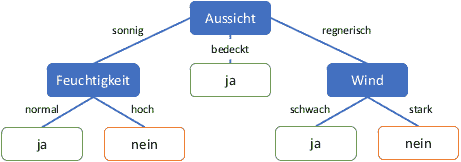

Im gegebenen Beispiel ist auch direkt ersichtlich, warum diese Art des Klassifikators als Entscheidungs**baum** bezeichnet wird. Diese Darstellung unterstreicht nämlich die hierarchisch angeordneten Regeln, die von der Wurzel zu den entfernten Blättern durchlaufen werden. Die Blätter - Knoten ohne Kinder - stellen die Klassen dar. Es müssen dabei nicht alle Attribute verwendet werden. Die Temperatur wurde beispielsweise nicht als entscheidendes Attribut in den Entscheidungsbaum übernommen.

Im Gegensatz zu diesem einfachen Beispiel, das sich mit niedrig-dimensionalen Daten an offensichtlichen Erfahrungswerten orientiert, ist die Erstellung eines Entscheidungsbaumes für komplexe Datensätze nicht immer von Hand möglich. Zumindest aber sind bei komplexen Fragestellungen Experten notwendig.

## Splits
Um automatisiert einen Entscheidungsbaum erstellen zu können ist es nun also notwendig, Kriterien für die Relevanz einer Aufteilung, auch Split genannt, zu finden. Diese Splits können entweder zu zwei (binär) oder mehr Verzweigungen führen. Dabei werden sie abhängig vom Typ des Attributs als kategorisch oder numerisch bezeichnet. Um die Anzahl der Verzweigungen zu reduzieren, kann es lohnenswert sein, numerische Attribute zu diskretisieren. (Dazu können Sie beispielsweise die Funktion `cut` aus Pandas verwenden.)

Ziel eines Splits sollte sein, die Menge aller Beispiele in möglichst wenigen Schritten zu teilen, bis Mengen mit ausschließlich einer einzelnen Klasse übrig bleiben. Es wird daher versucht, möglichst früh ein Attribut zu wählen, das *reine* Splits erzeugt. (*Rein* bedeutet in diesem Kontext, dass alle Elemente der entstandenen Menge die selbe Klasse besitzen.)

Zuerst wird also ein Maß für die Unreinheit benötigt. Der sogenannte Gini-Index - benannt nach Corrado Gini - kann für eine Partition von Trainingsobjekten wie folgt berechnet werden. Dabei ist $k$ die Anzahl an Klassen, $T$ eine Menge von Trainingsobjekten und $C_i \subseteq T$ genau die Teilmenge, die der $i$-ten Klasse zugeordnet wird.

$$
gini(T) = 1 - \sum_{i=1}^{k}\left(\dfrac{|C_i|}{|T|}\right)^2
$$

Anhand einiger Beispiele lässt sich feststellen, dass der Wert am größten ist, wenn die Elemente über alle Klassen gleichverteilt sind. Ein niedriger Wert spricht dagegen für eine hohe Reinheit. Im Falle binärer Splits lässt sich die Gleichung wie folgt in Python ausdrücken.

In [ ]:
def gini(T):
    return 1 - (len(T[T['class'] == 0]) / len(T)) ** 2 - (len(T[T['class'] == 1]) / len(T)) ** 2

Als nächstes wird ein Maß benötigt, das ein Attribut $A$ beispielsweise anhand des Gini-Index bewertet. Stellen Sie sich nun vor, dass das Attribut die Menge aller Trainingsbeispiele $T$ in mehrere Teilmengen $T_1, \dots, T_m$ zerlegt. Durch das Attribut Feuchtigkeit entstehen dabei beispielsweise die zwei Teilmengen $T_1$ (normal) und $T_2$ (hoch). Der Gini-Index wird anschließend anhand des relativen Anteils der Teilmenge gewichtet und zur Bewertung des Attributs herangezogen.

$$
gini_A(T) = \sum_{i=1}^{m}\dfrac{|T_i|}{|T|}*gini(T_i)
$$

Auch dieser Wert ist so konstruiert, dass ein Ergebnis nahe $0$ für eine hohe Reinheit spricht. In Python lässt sich diese Gleichung ebenfalls ausdrücken.

In [ ]:
def gini_A(T, A):
    T1, T2 = T[T[A] == 0], T[T[A] == 1]
    if len(T1) == 0 or len(T2) == 0:
        return 1

    return len(T1) / len(T) * gini(T1) + len(T2) / len(T) * gini(T2)

Die Bewertung des Splits ist nicht nur mit dem Gini-Index möglich. Alternativ lässt sich beispielsweise die Entropie verwenden, um ein Gütekriterium aufzustellen. Um die nachfolgende Funktion `construct_tree` zu verstehen, genügt der Gini-Index jedoch vollkommen.

## Konstruktion des Baumes
Die rekursive Funktion `construct_tree` erhält zwei Parameter. `T` bezeichnet die Trainingsmenge und `min_conf` die minimale Konfidenz. Der Ablauf gestaltet sich wie folgt:

1. Wenn die Konfidenz der Menge `T` die minimale Konfidenz überschreitet, endet der Aufruf.
2. Für jedes Attribut wird
    1. jeder mögliche Split
      - betrachtet und bewertet.
3. Der beste gefundene Split wird durchgeführt.
4. Die Teilmengen $T_1, \dots, T_m$ sind die durch diesen Split entstehenden Partitionen von T.
5. Für jede Teilmenge $T_1, \dots, T_m$ wird die Funktion `construct_tree` rekursiv aufgerufen.

Die folgende Funktion demonstriert den Ablauf ausschließlich für binäre Splits. Weiter unten werden Sie eine komplexere Funktion aus `scikit-learn` sehen, die auch für numerische Attribute geeignet ist.

In [ ]:
def construct_tree(T, min_conf):
    # Zuerst wird die Anzahl der Objekte jeder der zwei
    # möglichen Klassen bestimmt und gespeichert.
    count_0 = len(T[T['class'] == 0])
    count_1 = len(T[T['class'] == 1])

    # Die minimale Konfidenz bildet die Abbruchbedingung.
    if count_0 / len(T) >= min_conf:
        return 0
    if count_1 / len(T) >= min_conf:
        return 1

    # Anhand des Gini-Index wird das geeignetste Attribut
    # `A` gesucht. Der Split ist bei binären Entscheidungen
    # automatisch gegeben und muss nicht zusätzlich gefunden
    # werden.
    min_A = None
    min_score = 2

    for A in T.drop('class', axis=1):
        score = gini_A(T, A)
        if score < 1 and score < min_score:
            min_A = A
            min_score = score

    # Wenn kein Attribut gefunden werden konnte, wird die
    # Klasse zurückgegeben, der mehr Objekte angehören.
    if min_A is None:
        if count_0 >= count_1:
            return 0
        else:
            return 1

    # Falls ein Attribut gefunden wurde, wird der Split
    # durchgeführt. Bei binären Splits entstehen immer genau
    # zwei neue Teilmengen.
    T1 = T[T[min_A] == 0]
    T2 = T[T[min_A] == 1]

    # Für jede dieser Teilmengen wird die Funktion
    # `construct_tree` rekursiv aufgerufen.
    # Zurückgegeben wird ein Tupel der Form
    # (Attribut, Baum oder Klasse für 0, rechter Baum oder Klasse für 1).
    return min_A, construct_tree(T1, min_conf), construct_tree(T2, min_conf)

## Beispiel mit Trainingsdaten
Um einen ersten Entscheidungsbaum zu konstruieren, verwenden wir den Datensatz [banknote authentication Data Set](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). Enthalten sind verschiedene Features, die aus Aufnahmen von Geldscheinen extrahiert wurden, und eine Klasse, welche die Authentizität der Note repräsentiert.

Da der Algorithmus zunächst nur mit binären Entscheidungen arbeitet, wird eine konvertierte Version geladen.

In [ ]:
df_binary = pd.read_csv('data_banknote_authentication_binary.csv', sep=',')
df_binary

Mit diesem DataFrame wird anschließend die Funktion `construct_tree` aufgerufen.

In [ ]:
df_tree = construct_tree(df_binary, 0.9)
df_tree

Das entstandene, gestaffelte Tupel können Sie bereits von Hand auswerten und einige Beispiele damit klassifizieren. Die folgende Zelle stellt es abschließend als tatsächlichen Baum dar.

In [ ]:
from tree import draw
draw(df_tree)

Anhand der Baumdarstellung lässt sich auch einer der größten Vorteile von Entscheidungsbäumen erkennen. Man kann bis zu einer gewissen Komplexität die Entscheidungen nachvollziehen und leicht vermitteln.

## Implementierung in `scikit-learn`
`scikit-learn` bietet wie so oft eine fertige Implementierung für die Erstellung eines Entscheidungsbaums. Diese Funktion akzeptiert auch numerische Daten und findet ohne weitere Informationen die besten Splits. Zuerst wird daher der vollständige Datensatz geladen.

In [ ]:
df = pd.read_csv('data_banknote_authentication.csv', sep=',')
df

Zum Training ist es zuerst notwendig, die Daten in Features und Klassen zu teilen. Dazu werden zwei DataFrames erzeugt, wobei das erste alle Spalten außer `class` und das zweite ausschließlich die Spalte `class` enthält. Bei werden anschließend der Methode `fit` eines Objekts der Klasse `DecisionTreeClassifier` übergeben. Die erlernten Splits werden in diesem Objekt gespeichert.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X, y = df.drop('class', axis=1), df[['class']]
tree = DecisionTreeClassifier().fit(X, y)

Mit `plot_tree` steht außerdem eine Funktion bereit, die den entstandenen Baum grafisch darstellt. Verwenden Sie `pass` als letzte Anweisung in der Zelle, um die Ausgabe der exakten Koordinaten zu unterdrücken.

In [ ]:
from sklearn.tree import plot_tree
plot_tree(tree)

pass

## Random Forest